<a href="https://colab.research.google.com/github/CLAIR-LAB-TECHNION/energy-net/blob/main/notebooks/Running_the_day_ahead_market_cycle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Managing the Day-Ahead Market

electricity-market.svg

The objective of this tutorial is to demonstrate the process of running the day-ahead market. The setting we consider here includes two types of agents: the ISO, which sets the electricity production plan and the sell and feed-in tariffs, and the PCS units (production, consumption, and storage units) that participate in the market.

❗ Importantly, the PCSunit is a general entity that may be associated with various production, consumption, and storage functions (or only one of them). This means that it can be instantiated in many ways to represent, for example, a battery (only storage), a household (with all three capabilities), or a city (with any relevant combination of the three). This generalization is a software engineering concept that allows us to create code that is varsetile and adaptable.

## Decision-Operational Cycle:


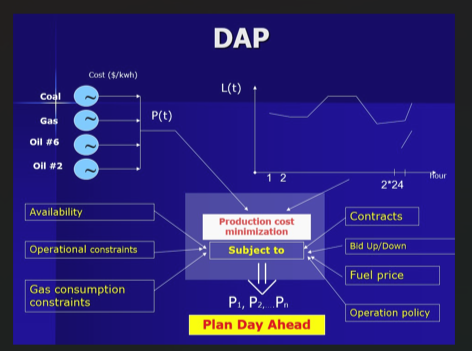

As a first step, we deal with the day-ahead market under the assumption that all the information is known and all the decisions are made at time 0. We will later relax these assumptions.  


We are considering a 24- hour decision horizon of 48 half-hour intervales.

The input includes:
- the predicted demand $\hat{D}$ for each timestep (interval) in the decision horizon
- the production capabilities and costs of the units controlled by the ISO for each timestep (and its controlled units)
- the production, storage, and transmission bounds on each PCSUnit






The iterative process includes at every iteration (every 24-hours at timestep 0):
- the ISO sets the Day-Ahead Program (DAP) that sets the amount of electricity to produce at each timestep
- the ISO sets the sell and feed-in tariffs per timestep for the entire decision horizon
- the PCSUnits see the prices and decide how much power to store, sell/buy, and consume at every timestep. In practice, since the demand (a.k.a load) needs to be satisfied and agents either sell or buy and either charge and discharge their battery, the decision at time t is often reflected by one decision variable that considers the storage action (charge/discharge).

This process continues until convergence (and before timestep 1)

## Assumptions (for now):

*  All decisions are made at time 0. This means that the policies are fixed at time 0 and while an  agent can choose its current action based on the real-time state at any timestep t, the policy (mapping from states of actions) is fixed at timestep 0, i.e., there is no real-time update of policies
* As a first step, we assume that the predicted and realized demands are equal
* The DAP process is abstracted, i.e., we do not deal with how the generation is distributed among controlled production agents. We only deal with the high-level decision of how much to generate and the pricing of energy
* For now, the demand is modeled as a sinusoidal for which the user sets the parameters. Later on, we will integrate more elaborate ways to define demand
* Similarly, the production costs are fixed (per unit and per timestep). This too will be extended to support elaborate functions   



#The `energy-net` Environment

As a reminder, `energy-net` is a package we are developing for smart grid simulation, designed to model and simulate energy dynamics in a network of interconnected entities.


This is the repo's link [https://github.com/CLAIR-LAB-TECHNION/energy-net](https://github.com/CLAIR-LAB-TECHNION/energy-net)

##Step 1: Setting Up the `energy-net` Environment

First, we setup the` energynet ` environment by installing it. No need to do anything beyond running the cell.

In [3]:
!git clone https://github.com/CLAIR-LAB-TECHNION/energy-net.git

%cd energy-net
!pip install -e .

Cloning into 'energy-net'...
remote: Enumerating objects: 4280, done.
remote: Counting objects: 100% (495/495), done.
remote: Compressing objects: 100% (301/301), done.
remote: Total 4280 (delta 210), reused 383 (delta 184), pack-reused 3785 (from 1)
Receiving objects: 100% (4280/4280), 866.97 MiB | 23.74 MiB/s, done.
Resolving deltas: 100% (1691/1691), done.
/content/energy-net/energy-net
Obtaining file:///content/energy-net/energy-net
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for energy-net (pyproject.toml) ... done
  Created wheel for energy-net: filename=energy_net-0.0.0-0.editable-py3-none-any.whl size=3859 sha256=4427a92a1a6ce043d5ded0d2d5e175d231344eadb4cc3c2f9965edc5ed6a3b80
  Stored in directory: /tmp/pip-ephem-wheel-cache-cu8iaa3o/wheels/20/a8/9d/b8d9127cbd5d725885a24a070bb86334fad0d6cd4e535d7

In [4]:
## add to requirements later !
!pip install ruamel.yaml


# Setting up a simulation

While you run the notebook, you will be required to configure some values. When this is required, a text box appears below the cell and execution will pose until the values are set. For example:

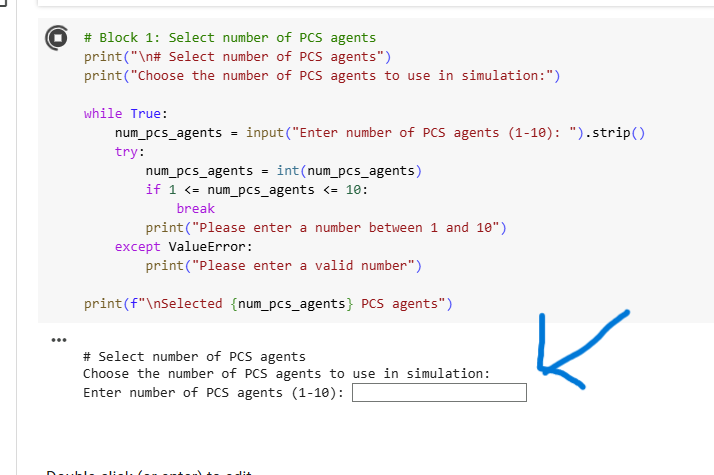

## Step 1: Selecting a Pricing Mechanism


First, we select the pricing mechanism that will be used for the simulation.

We are considering four options:
- INTERVALS: two price levels per day in response to demand level
- QUADRATIC: quadratic (sublinear) prices for purchasing (selling) power from (to) the ISO
- ONLINE: prices are set in response to market signals. This option is currently not active but will be implemented later on
- RANDOM: a random assignment of prices

In [5]:
use_default = input("Use default QUADRATIC pricing mechanism? (yes/no): ").strip().lower()
if use_default == "yes":
    # Skip the interactive prompt and default to QUADRATIC
    pricing_mechanism = "QUADRATIC"
    pcs_agent_config_path = "configs/pcs_agent_quadratic.json"
    print("Defaulting to QUADRATIC.")
else:
    print("Select a pricing mechanism (this will be used as a constant parameter):")
    print("1: INTERVALS   (two price levels in response to demand level)")
    print("2: QUADRATIC   (quadratic/sublinear prices for power purchase/sale)")
    print("3: ONLINE      (currently inactive, to be implemented)")
    print("4: RANDOM      (random pricing)")

    pricing_choice = input("Enter 1, 2, 3, or 4: ").strip()

    if pricing_choice == "1":
        pricing_mechanism = "INTERVALS"
        pcs_agent_config_path = "configs/pcs_agent_intervals.json"  # example path
    elif pricing_choice == "2":
        pricing_mechanism = "QUADRATIC"
        pcs_agent_config_path = "configs/pcs_agent_quadratic.json"
    elif pricing_choice == "3":
        pricing_mechanism = "ONLINE"
        pcs_agent_config_path = "configs/pcs_agent_online.json"
    elif pricing_choice == "4":
        pricing_mechanism = "RANDOM"
        pcs_agent_config_path = "configs/pcs_agent_random.json"
    else:
        print("Invalid input; defaulting to QUADRATIC")
        pricing_mechanism = "QUADRATIC"
        pcs_agent_config_path = "configs/pcs_agent_quadratic.json"

print(f"Selected pricing mechanism: {pricing_mechanism}")


Use default QUADRATIC pricing mechanism? (yes/no): yes
Defaulting to QUADRATIC.
Selected pricing mechanism: QUADRATIC


## Step 2: Selecting a Demand Pattern

Here, we select the pattern of the expected demand. This will be used to set the daily dispatch.

In [6]:
print("\n# Select Demand Pattern")
print("Choose a demand pattern for the simulation:")
print("1: SINUSOIDAL  (smooth daily cycle with one peak)")
print("2: CONSTANT    (fixed demand level)")
print("3: DOUBLE_PEAK (morning and evening peaks)")

use_default = input("Use default (SINUSOIDAL)? (yes/no): ").strip().lower()
if use_default == "yes":
    demand_pattern = "SINUSOIDAL"
    print("Defaulting to SINUSOIDAL.")
else:
    while True:
        demand_choice = input("Enter 1, 2, or 3: ").strip()
        if demand_choice == "1":
            demand_pattern = "SINUSOIDAL"
            break
        elif demand_choice == "2":
            demand_pattern = "CONSTANT"
            break
        elif demand_choice == "3":
            demand_pattern = "DOUBLE_PEAK"
            break
        else:
            print("Invalid input; please enter 1, 2, or 3")

print(f"\nSelected demand pattern: {demand_pattern}")



# Select Demand Pattern
Choose a demand pattern for the simulation:
1: SINUSOIDAL  (smooth daily cycle with one peak)
2: CONSTANT    (fixed demand level)
3: DOUBLE_PEAK (morning and evening peaks)
Use default (SINUSOIDAL)? (yes/no): yes
Defaulting to SINUSOIDAL.

Selected demand pattern: SINUSOIDAL


## Step 3: Selecting and loading the PCS units (and their associated marktet players) and setting their paramaters


First, we select the number of PCS units

In [7]:
print("\n# Select number of PCS agents")
print("Choose the number of PCS agents to use in simulation:")

use_default = input("Use default (1 PCS agent)? (yes/no): ").strip().lower()
if use_default == "yes":
    num_pcs_agents = 1
    print("Defaulting to 1 PCS agent.")
else:
    while True:
        user_input = input("Enter number of PCS agents (1-10): ").strip()
        try:
            num_pcs_agents = int(user_input)
            if 1 <= num_pcs_agents <= 10:
                break
            print("Please enter a number between 1 and 10.")
        except ValueError:
            print("Please enter a valid number.")

print(f"\nSelected {num_pcs_agents} PCS agent(s).")



# Select number of PCS agents
Choose the number of PCS agents to use in simulation:
Use default (1 PCS agent)? (yes/no): yes
Defaulting to 1 PCS agent.

Selected 1 PCS agent(s).


We now load onf of the pre-trained agents that were trained using the different pricing models. While the agent (and policy) will be shared, we can later set the internal parameters of each PCS unit if we want (e.g., storage capacity).

For running the notebook, we have pre-trained 4 pcsunit agents:


1.  INTERVALS: two price levels in response to demand level
2.  QUADRATIC: quadratic (sublinear) prices for purchasing (selling) power from (to) the ISO
3.  ONLINE: currently not active: will be implemented later on
4. RANDOM: a random

Note that these correspond to the pricing approaches that can be chosen above.

In [9]:
if pricing_mechanism == "INTERVALS":
    pcs_agent_config_path = "configs/pcs_agent_intervals.json"
elif pricing_mechanism == "QUADRATIC":
    pcs_agent_config_path = "configs/pcs_agent_quadratic.json"
elif  pricing_mechanism == "ONLINE":
    pcs_agent_config_path = "configs/pcs_agent_online.json"
elif pricing_mechanism == "RANDOM":
    pcs_agent_config_path = "configs/pcs_agent_random.json"
else:
    print("Invalid input; defaulting to QUADRATIC")
    pricing_mechanism = "QUADRATIC"
    pcs_agent_config_path = "configs/pcs_agent_quadratic.json"



Load the PCS agent (the trained policy that will be shared by the PCS units)

In [10]:
# Load the corresponding PCS agent configuration
def load_pcs_agent(config_path):
    # Replace this placeholder with our actual PCS agent loading function
    return f"Loaded PCS agent from {config_path}"

pcs_agent = load_pcs_agent(pcs_agent_config_path)
print("PCS Agent loaded:", pcs_agent)


PCS Agent loaded: Loaded PCS agent from configs/pcs_agent_quadratic.json


### Update PCS Battery Parameters

We now set the characteristics of the PCS units. For now, we only set the storage parameters.




In [11]:
# Block 3: Configure PCS Agents Battery Parameters
from ruamel.yaml import YAML
import os

print("\n# Configure PCS Agents")
configs_path = os.path.join("configs", "pcs_configs.yaml")
yaml_obj = YAML()
yaml_obj.preserve_quotes = True

# Load or create config file
try:
    with open(configs_path, "r") as file:
        all_configs = yaml_obj.load(file)
except Exception as e:
    print(f"Creating new config file: {e}")
    all_configs = {}

# Ask if we want to default all agents' battery parameters
use_defaults = input("Use default battery parameters for ALL PCS agents? (yes/no): ").strip().lower()
if use_defaults == "yes":
    # Default config
    default_battery = {
        "dynamic_type": "model_based",
        "model_parameters": {
            "charge_efficiency": 1.0,
            "charge_rate_max": 10.0,
            "discharge_efficiency": 1.0,
            "discharge_rate_max": 10.0,
            "init": 0.0,
            "max": 100.0
        }
    }
    for agent_idx in range(num_pcs_agents):
        agent_key = f"pcs_{agent_idx + 1}"
        all_configs[agent_key] = {"battery": default_battery}
        print(f"Defaulted battery parameters for {agent_key}.")
else:
    # Existing interactive logic
    editable_params = [
        "charge_efficiency",
        "charge_rate_max",
        "discharge_efficiency",
        "discharge_rate_max",
        "init",
        "max"
    ]
    for agent_idx in range(num_pcs_agents):
        agent_key = f"pcs_{agent_idx + 1}"
        print(f"\nConfiguring {agent_key}:")

        # Create default config if doesn't exist
        if agent_key not in all_configs:
            all_configs[agent_key] = {
                "battery": {
                    "dynamic_type": "model_based",
                    "model_parameters": {
                        "charge_efficiency": 0.9,
                        "charge_rate_max": 9.0,
                        "discharge_efficiency": 0.9,
                        "discharge_rate_max": 9.0,
                        "init": 9.0,
                        "max": 99.0
                    }
                }
            }

        # Show and edit battery parameters
        battery_params = all_configs[agent_key]["battery"]["model_parameters"]
        print("\nCurrent battery parameters:")
        for param in editable_params:
            print(f"{param}: {battery_params.get(param)}")

        # Ask to edit
        edit_choice = input(f"\nDo you want to edit battery parameters for {agent_key}? (yes/no): ").strip().lower()
        if edit_choice == "yes":
            for param in editable_params:
                current = battery_params[param]
                new_value = input(f"Enter new {param} (current={current}): ").strip()
                if new_value:  # Only update if user entered a value
                    battery_params[param] = float(new_value)

# Save updated configs
with open(configs_path, "w") as file:
    yaml_obj.dump(all_configs, file)
print(f"\nPCS battery configurations saved to {configs_path}.")



# Configure PCS Agents
Creating new config file: [Errno 2] No such file or directory: 'configs/pcs_configs.yaml'
Use default battery parameters for ALL PCS agents? (yes/no): yes
Defaulted battery parameters for pcs_1.

PCS battery configurations saved to configs/pcs_configs.yaml.


Afer setting the paremeters, we now update the values

In [12]:
# Block: Add Fixed Parameters
for agent_key in all_configs:
    # Add fixed battery parameters
    battery_params = all_configs[agent_key]["battery"]["model_parameters"]
    battery_params.update({
        "lifetime_constant": 100.0,
        "min": 0.0,
        "model_type": "deterministic_battery"
    })

    # Add consumption unit with fixed parameters
    all_configs[agent_key]["consumption_unit"] = {
        "dynamic_type": "model_based",
        "model_type": "deterministic_consumption",
        "model_parameters": {
            "consumption_capacity": 0.0,
            "peak_consumption1": 0.0,
            "peak_consumption2": 0.0,
            "peak_time1": 0.4,
            "peak_time2": 0.7,
            "width1": 0.05,
            "width2": 0.1
        }
    }

    # Add production unit with fixed parameters
    all_configs[agent_key]["production_unit"] = {
        "dynamic_type": "model_based",
        "model_type": "deterministic_production",
        "model_parameters": {
            "peak_production": 0.0,
            "peak_time": 0.5,
            "production_capacity": 0.0,
            "width": 0.1
        }
    }


Save complete configuration


In [13]:

# Save complete configuration
try:
    with open(configs_path, "w") as file:
        yaml_obj.dump(all_configs, file)
    print("\nAll PCS configurations saved successfully.")
except Exception as e:
    print(f"Error saving configurations: {e}")


All PCS configurations saved successfully.


## Step 3: ISO Setup


In this simulation, the ISO is the agent that is trained. We now set up its training parameters.



*   **total_iterations** - controls how many times you repeat the train+evaluate cycle
*   **train_timesteps_per_iteration** - tells you how long each training phase should be in terms of environment interactions.
*   **eval_episodes** - tells you how many episodes you use to measure performance each time you do an evaluation.




In [19]:
# Block 2: Set ISO Training Parameters

print("\n--- ISO Training Parameter Setup ---")

use_default = input("Use default ISO training parameters? (10 iterations, 8000 timesteps, 5 eval episodes) (yes/no): ").strip().lower()
if use_default == "yes":
    total_iterations = 10
    train_timesteps_per_iteration = 8000
    eval_episodes = 5
    print("Defaulting to (total_iterations=10, timesteps_per_iteration=8000, eval_episodes=5).")
else:
    try:
        total_iterations = int(input("Enter total iterations (e.g., 10): ").strip())
    except:
        total_iterations = 10

    try:
        train_timesteps_per_iteration = int(input("Enter timesteps per iteration (e.g., 10000): ").strip())
    except:
        train_timesteps_per_iteration = 10000

    try:
        eval_episodes = int(input("Enter number of evaluation episodes (e.g., 5): ").strip())
    except:
        eval_episodes = 5

print(f"\nISO Training will use the pricing mechanism: {pricing_mechanism}")

# Save ISO parameters to a dictionary for later use
iso_params = {
    "total_iterations": total_iterations,
    "train_timesteps_per_iteration": train_timesteps_per_iteration,
    "eval_episodes": eval_episodes,
    "pricing_mechanism": pricing_mechanism
}

print(f"Selected ISO parameters: {iso_params}")



--- ISO Training Parameter Setup ---
Use default ISO training parameters? (10 iterations, 8000 timesteps, 5 eval episodes) (yes/no): yes
Defaulting to (total_iterations=10, timesteps_per_iteration=8000, eval_episodes=5).

ISO Training will use the pricing mechanism: QUADRATIC
Selected ISO parameters: {'total_iterations': 10, 'train_timesteps_per_iteration': 8000, 'eval_episodes': 5, 'pricing_mechanism': 'QUADRATIC'}


# Running a simulation: Training the ISO

In [22]:
# Block 4: Training

print("\nStarting training...")
from iso_game_main import train_and_evaluate_agent, PricingPolicy
from energy_net.dynamics.iso.demand_patterns import DemandPattern
from energy_net.dynamics.iso.cost_types import CostType
import random


# Map the selected pricing mechanism to the corresponding PricingPolicy Enum value:
if pricing_mechanism == "QUADRATIC":
    pricing_policy_enum = PricingPolicy.QUADRATIC
elif pricing_mechanism == "INTERVALS":
    pricing_policy_enum = PricingPolicy.INTERVALS
elif pricing_mechanism == "ONLINE":
    pricing_policy_enum = PricingPolicy.ONLINE
elif pricing_mechanism == "RANDOM":
    pricing_policy_enum = PricingPolicy.RANDOM
else:
    pricing_policy_enum = PricingPolicy.QUADRATIC

# Convert the selected demand pattern to enum
demand_pattern_enum = DemandPattern[demand_pattern]


seed = random.randint(0, 10000)

train_and_evaluate_agent(
    algo_type='PPO',
    num_pcs_agents=num_pcs_agents,
    trained_pcs_model_path=pcs_agent,
    pricing_policy=pricing_policy_enum,
    demand_pattern=demand_pattern_enum,
    cost_type=CostType["CONSTANT"],
    total_iterations=iso_params["total_iterations"],
    train_timesteps_per_iteration=iso_params["train_timesteps_per_iteration"],
    eval_episodes=iso_params["eval_episodes"],
    seed=seed
)


Starting training...


/usr/local/lib/python3.11/dist-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/usr/local/lib/python3.11/dist-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Output()

Starting iterative training for 10 iterations.
Training ISO, using current ISO model


Runtime info saved to runtime_info.pkl

[ISO] Mean Reward: -98570534.13 +/- 95195640.50
Saved flows and prices plot to logs/agent_iso/episode_0_flows_prices.png
Saved cost components plot to logs/agent_iso/episode_0_cost_components.png


Output()

Saved final cost distribution plot to logs/agent_iso/episode_0_final_cost_distribution.png
Training ISO, using current ISO model


Runtime info saved to runtime_info.pkl

[ISO] Mean Reward: -99018557.64 +/- 95303341.19
Saved flows and prices plot to logs/agent_iso/episode_1_flows_prices.png
Saved cost components plot to logs/agent_iso/episode_1_cost_components.png


Output()

Saved final cost distribution plot to logs/agent_iso/episode_1_final_cost_distribution.png
Training ISO, using current ISO model


Runtime info saved to runtime_info.pkl

[ISO] Mean Reward: -98968032.71 +/- 95291528.42
Saved flows and prices plot to logs/agent_iso/episode_2_flows_prices.png
Saved cost components plot to logs/agent_iso/episode_2_cost_components.png


Output()

Saved final cost distribution plot to logs/agent_iso/episode_2_final_cost_distribution.png
Training ISO, using current ISO model


Runtime info saved to runtime_info.pkl

[ISO] Mean Reward: -98080263.41 +/- 95078680.71
Saved flows and prices plot to logs/agent_iso/episode_3_flows_prices.png
Saved cost components plot to logs/agent_iso/episode_3_cost_components.png


Output()

Saved final cost distribution plot to logs/agent_iso/episode_3_final_cost_distribution.png
Training ISO, using current ISO model


Runtime info saved to runtime_info.pkl

[ISO] Mean Reward: -96561945.62 +/- 94714555.85
Saved flows and prices plot to logs/agent_iso/episode_4_flows_prices.png
Saved cost components plot to logs/agent_iso/episode_4_cost_components.png


Output()

Saved final cost distribution plot to logs/agent_iso/episode_4_final_cost_distribution.png
Training ISO, using current ISO model


Runtime info saved to runtime_info.pkl

[ISO] Mean Reward: -94762839.83 +/- 94283136.78
Saved flows and prices plot to logs/agent_iso/episode_5_flows_prices.png
Saved cost components plot to logs/agent_iso/episode_5_cost_components.png


Output()

Saved final cost distribution plot to logs/agent_iso/episode_5_final_cost_distribution.png
Training ISO, using current ISO model


Runtime info saved to runtime_info.pkl

[ISO] Mean Reward: -92802383.96 +/- 93812908.99
Saved flows and prices plot to logs/agent_iso/episode_6_flows_prices.png
Saved cost components plot to logs/agent_iso/episode_6_cost_components.png


Output()

Saved final cost distribution plot to logs/agent_iso/episode_6_final_cost_distribution.png
Training ISO, using current ISO model


Runtime info saved to runtime_info.pkl

[ISO] Mean Reward: -90692085.45 +/- 93306979.01
Saved flows and prices plot to logs/agent_iso/episode_7_flows_prices.png
Saved cost components plot to logs/agent_iso/episode_7_cost_components.png


Output()

Saved final cost distribution plot to logs/agent_iso/episode_7_final_cost_distribution.png
Training ISO, using current ISO model


Runtime info saved to runtime_info.pkl

[ISO] Mean Reward: -88580107.50 +/- 92800794.56
Saved flows and prices plot to logs/agent_iso/episode_8_flows_prices.png
Saved cost components plot to logs/agent_iso/episode_8_cost_components.png


Output()

Saved final cost distribution plot to logs/agent_iso/episode_8_final_cost_distribution.png
Training ISO, using current ISO model


Runtime info saved to runtime_info.pkl

[ISO] Mean Reward: -86582301.85 +/- 92322167.24
Saved flows and prices plot to logs/agent_iso/episode_9_flows_prices.png
Saved cost components plot to logs/agent_iso/episode_9_cost_components.png
Saved final cost distribution plot to logs/agent_iso/episode_9_final_cost_distribution.png
Iterative training completed.
Final ISO model saved to models/agent_iso/agent_iso_final.zip
Training and evaluation process completed.


/usr/local/lib/python3.11/dist-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/usr/local/lib/python3.11/dist-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Final ISO Model - Mean Reward: -62700703.062130906 +/- 84560633.92932658


# Evaluation

In [24]:
print("----- Evaluation / Visualizations -----")

trained_model_path = "models/agent_iso/agent_iso_final.zip"           # Final ISO model path
normalizer_path = "models/agent_iso/agent_iso_normalizer.pkl"           # Normalizer path
trained_pcs_model_path = "None"


----- Evaluation / Visualizations -----


In [26]:
# --- Evaluation / Visualization Block ---

print("\n--- Evaluation / Visualizations ---")

# 1. Import the evaluation function and enums (similar to how you did with training)
from eval_agent import evaluate_trained_model
from energy_net.dynamics.iso.demand_patterns import DemandPattern
from iso_game_main import PricingPolicy

# 2. Prompt the user for eval_episodes (or default)
eval_episodes = iso_params.get("eval_episodes", 5)
user_input = input(f"Enter number of evaluation episodes (default {eval_episodes}): ").strip()
if user_input:
    try:
        eval_episodes = int(user_input)
    except ValueError:
        print("Invalid input; using default value.")

# 3. Convert your selected strings (pricing_mechanism, demand_pattern) to enum values
if pricing_mechanism == "QUADRATIC":
    pricing_policy_enum = PricingPolicy.QUADRATIC
elif pricing_mechanism == "INTERVALS":
    pricing_policy_enum = PricingPolicy.INTERVALS
elif pricing_mechanism == "ONLINE":
    pricing_policy_enum = PricingPolicy.ONLINE
elif pricing_mechanism == "RANDOM":
    pricing_policy_enum = PricingPolicy.RANDOM
else:
    pricing_policy_enum = PricingPolicy.QUADRATIC

demand_pattern_enum = DemandPattern[demand_pattern]




# 4. Print what we’re about to do
print(f"\nRunning evaluation using pricing mechanism: {pricing_mechanism}")
print("Evaluation parameters:")
print(f"  Normalizer: {normalizer_path}")
print(f"  Trained PCS model: {trained_pcs_model_path}")
print(f"  Evaluation episodes: {eval_episodes}")

# 5. Call the evaluation function in-process (instead of subprocess)
evaluate_trained_model(
    trained_model_path=trained_model_path,
    normalizer_path=normalizer_path,
    env_id="ISOEnv-v0",
    eval_episodes=eval_episodes,
    algo_type="PPO",
    pricing_policy=pricing_policy_enum,
    trained_pcs_model_path=trained_pcs_model_path,
    demand_pattern=demand_pattern_enum,
    num_pcs_agents=num_pcs_agents,
    cost_type=CostType["CONSTANT"]
)

print("\nEvaluation completed.")



--- Evaluation / Visualizations ---
Enter number of evaluation episodes (default 5): 2

Running evaluation using pricing mechanism: QUADRATIC
Evaluation parameters:
  Normalizer: models/agent_iso/agent_iso_normalizer.pkl
  Trained PCS model: None
  Evaluation episodes: 2

Starting Episode 1/2
Episode 1 completed - Reward: -18853353.57
Saved flows and prices plot to evaluation_results/episode_0_flows_prices.png
Saved cost components plot to evaluation_results/episode_0_cost_components.png
Saved final cost distribution plot to evaluation_results/episode_0_final_cost_distribution.png

Starting Episode 2/2
Episode 2 completed - Reward: 3710236.64
Saved flows and prices plot to evaluation_results/episode_1_flows_prices.png
Saved cost components plot to evaluation_results/episode_1_cost_components.png
Saved final cost distribution plot to evaluation_results/episode_1_final_cost_distribution.png
Evaluation completed - Check evaluation_results directory for plots

Evaluation completed.


# Visualizations

In [27]:
import pickle
import random
import matplotlib.pyplot as plt
import numpy as np

# Load runtime data from file (this file should have been created by your callback)
runtime_file = "runtime_info.pkl"
try:
    with open(runtime_file, "rb") as f:
        all_episodes_actions = pickle.load(f)
    print(f"Loaded runtime data with {len(all_episodes_actions)} episodes.")
except Exception as e:
    print("Error loading runtime data:", e)
    all_episodes_actions = []

if not all_episodes_actions:
    print("No data available to plot.")
else:
    # Select a random episode for detailed time-series plots
    episode_num = random.randint(1, len(all_episodes_actions))
    episode_data = all_episodes_actions[episode_num - 1]

    # Extract data from the episode
    steps = [step.get('step', 0) for step in episode_data]
    dispatch = [step.get('dispatch', 0.0) for step in episode_data]
    predicted_demand = [step.get('predicted_demand', 0.0) for step in episode_data]
    realized_demand = [step.get('realized_demand', 0.0) for step in episode_data]
    net_exchange = [step.get('net_exchange', 0.0) for step in episode_data]
    battery_level = [step.get('battery_level', 0.0) for step in episode_data]
    actions = [step.get('action', 0.0) for step in episode_data]
    iso_sell_price = [step.get('iso_sell_price', 0.0) for step in episode_data]
    iso_buy_price = [step.get('iso_buy_price', 0.0) for step in episode_data]

    # Compute total (net) demand: realized_demand + net_exchange
    net_demand = [r + n for r, n in zip(realized_demand, net_exchange)]


Loaded runtime data with 1700 episodes.


**Energy Flows:** Time-series view of dispatch, predicted, realized, and net demand

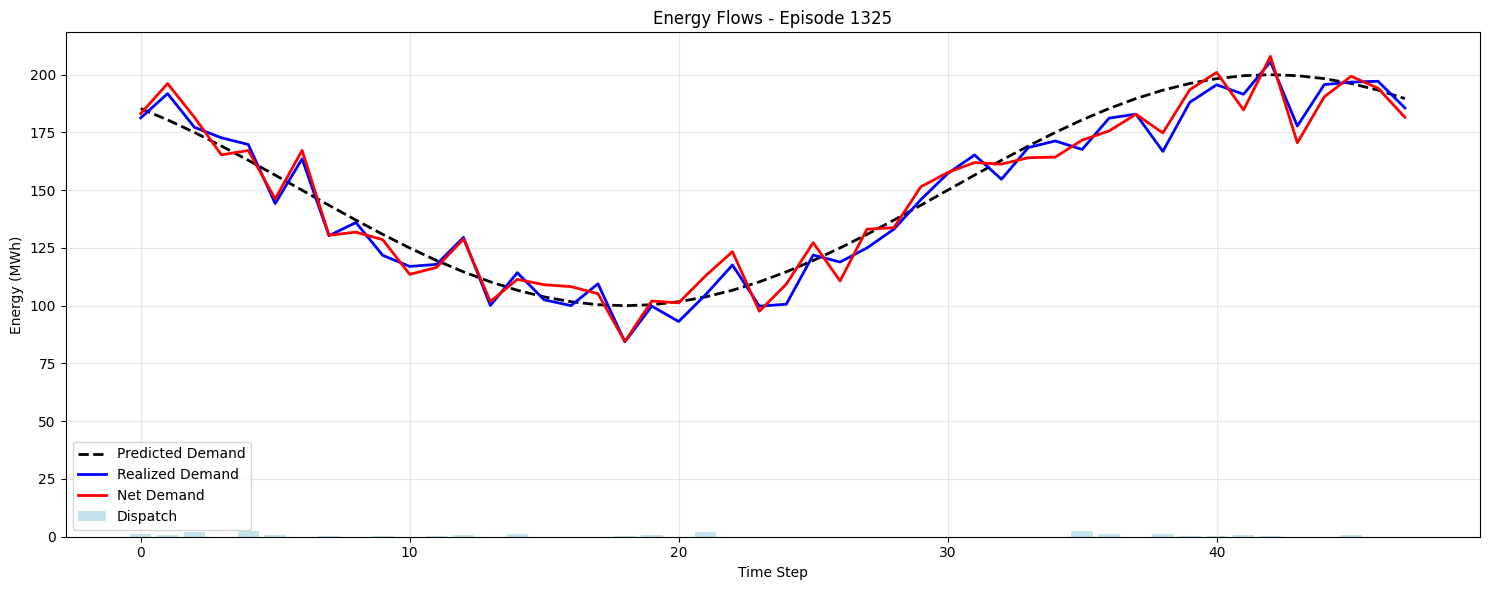

In [28]:
# Plot 1: Energy Flows
plt.figure(figsize=(15, 6))
plt.bar(steps, dispatch, width=0.8, color='lightblue', alpha=0.7, label='Dispatch')
plt.plot(steps, predicted_demand, 'k--', linewidth=2, label='Predicted Demand')
plt.plot(steps, realized_demand, 'b-', linewidth=2, label='Realized Demand')
plt.plot(steps, net_demand, 'r-', linewidth=2, label='Net Demand')
plt.xlabel("Time Step")
plt.ylabel("Energy (MWh)")
plt.title(f"Energy Flows - Episode {episode_num}")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


**Battery Dynamics & Actions:** Tracking battery levels alongside agent actions.

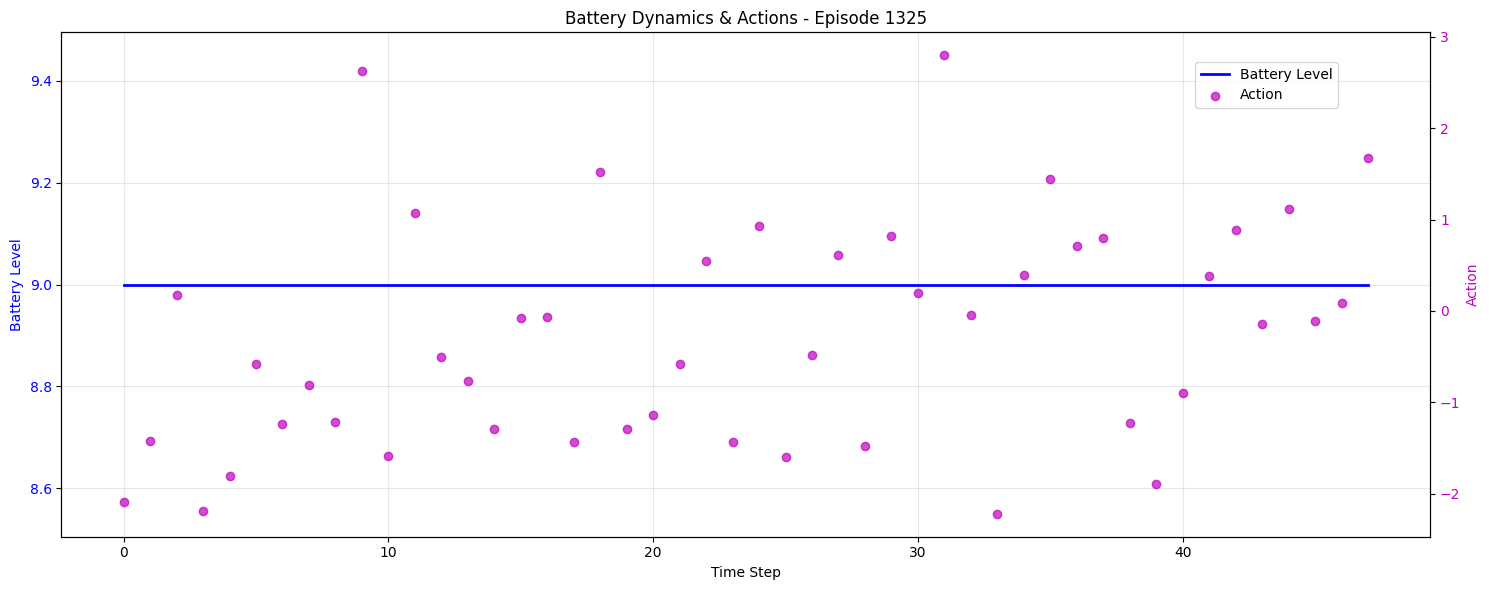

In [29]:
# Plot 2: Battery Level & Actions over Time
fig, ax1 = plt.subplots(figsize=(15, 6))
ax1.plot(steps, battery_level, 'b-', linewidth=2, label='Battery Level')
ax1.set_xlabel("Time Step")
ax1.set_ylabel("Battery Level", color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.grid(True, alpha=0.3)

# Plot actions on a secondary axis
ax2 = ax1.twinx()
ax2.scatter(steps, actions, color='m', label='Action', alpha=0.7)
ax2.set_ylabel("Action", color='m')
ax2.tick_params(axis='y', labelcolor='m')

plt.title(f"Battery Dynamics & Actions - Episode {episode_num}")
fig.legend(loc="upper right", bbox_to_anchor=(0.9, 0.9))
plt.tight_layout()
plt.show()


**Cost Breakdown per Episode:** A stacked bar chart showing cumulative dispatch, reserve, and shortfall costs.

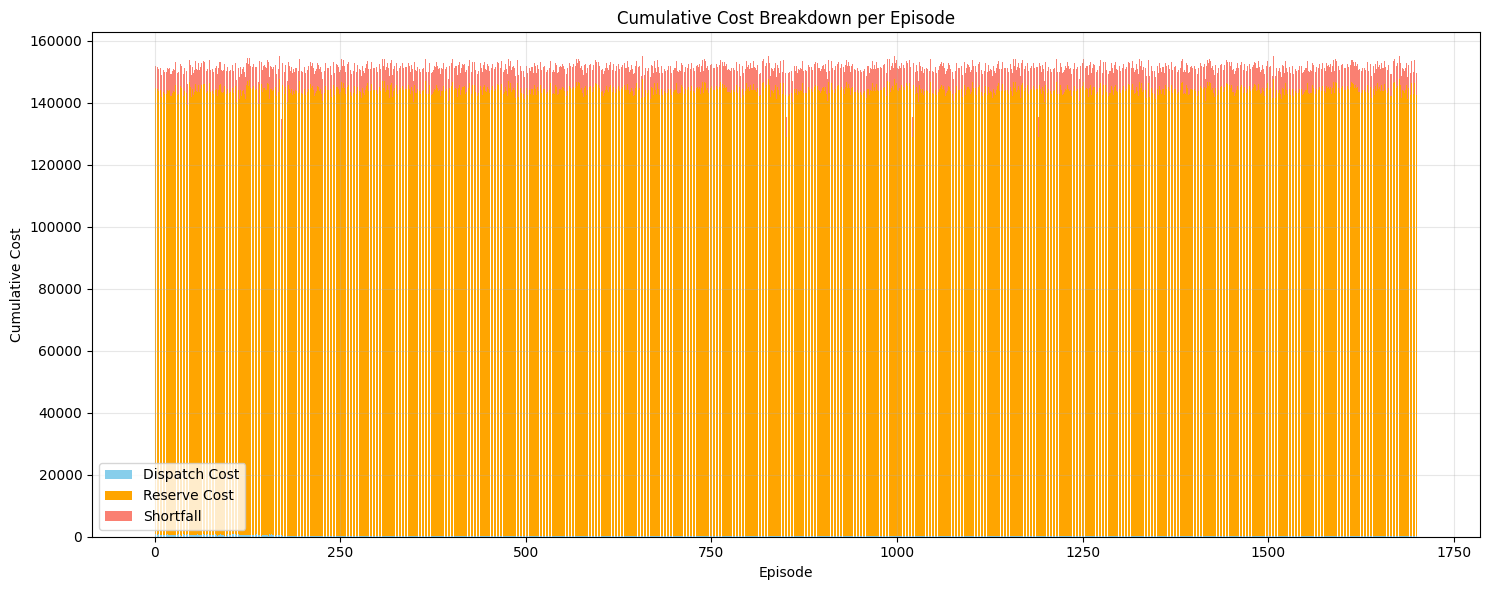

In [30]:
# Plot 3: Cost Breakdown per Episode (Aggregated over Episodes)
cumulative_dispatch_cost = []
cumulative_reserve_cost = []
cumulative_shortfall = []
episode_indices = list(range(1, len(all_episodes_actions) + 1))

for ep in all_episodes_actions:
    dispatch_cost = sum(step.get('dispatch_cost', 0.0) for step in ep)
    reserve_cost = sum(step.get('reserve_cost', 0.0) for step in ep)
    shortfall = sum(step.get('shortfall', 0.0) for step in ep)
    cumulative_dispatch_cost.append(dispatch_cost)
    cumulative_reserve_cost.append(reserve_cost)
    cumulative_shortfall.append(shortfall)

plt.figure(figsize=(15, 6))
plt.bar(episode_indices, cumulative_dispatch_cost, label='Dispatch Cost', color='skyblue')
plt.bar(episode_indices, cumulative_reserve_cost, bottom=cumulative_dispatch_cost, label='Reserve Cost', color='orange')
bottom_stack = np.array(cumulative_dispatch_cost) + np.array(cumulative_reserve_cost)
plt.bar(episode_indices, cumulative_shortfall, bottom=bottom_stack, label='Shortfall', color='salmon')
plt.xlabel("Episode")
plt.ylabel("Cumulative Cost")
plt.title("Cumulative Cost Breakdown per Episode")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


**Prediction Accuracy:** Scatter plot comparing predicted and realized demand with an ideal 45° reference.

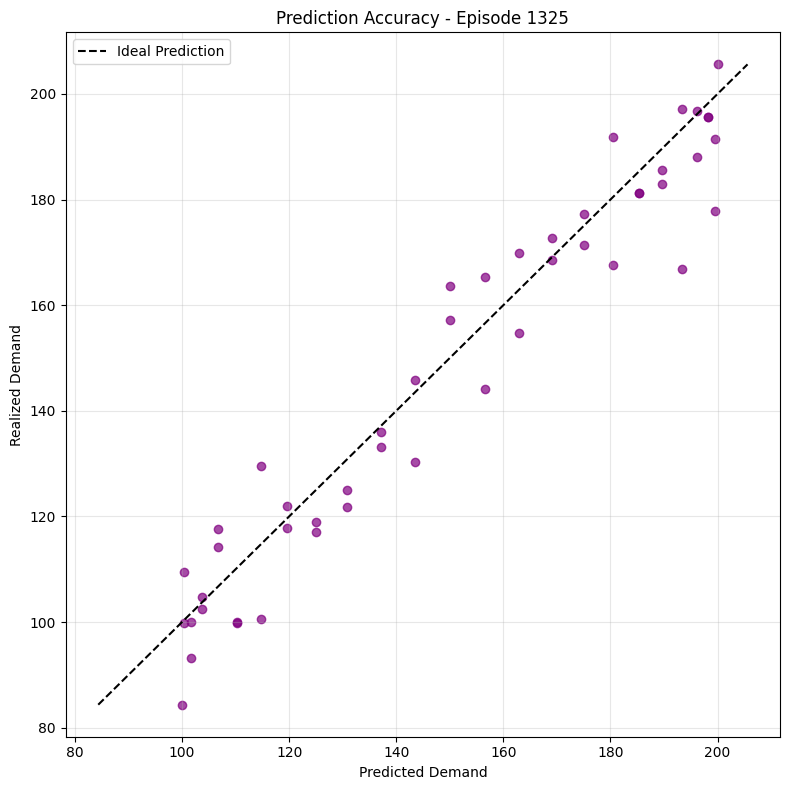

In [31]:
# Plot 4: Prediction Accuracy (Scatter Plot)
plt.figure(figsize=(8, 8))
plt.scatter(predicted_demand, realized_demand, alpha=0.7, color='purple')
min_val = min(min(predicted_demand), min(realized_demand))
max_val = max(max(predicted_demand), max(realized_demand))
plt.plot([min_val, max_val], [min_val, max_val], 'k--', label='Ideal Prediction')
plt.xlabel("Predicted Demand")
plt.ylabel("Realized Demand")
plt.title(f"Prediction Accuracy - Episode {episode_num}")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
